# Лабораторная работа №5.  Подходы к распознанию именованных сущностей NER (Named Entity Recognition)

***NER (Named Entity Recognition)*** - это задача обнаружения и классификации именованных сущностей в тексте, таких как имена людей, места, организации, даты, числовые выражения и другие нестандартные сущности. Цель NER заключается в том, чтобы извлечь и классифицировать указанные сущности в тексте и выделить их контекстуальные значения.

Примеры именованных сущностей, которые может распознать система NER:
- PER (Person) - имена людей
- LOC (Location) - географические места
- ORG (Organization) - названия организаций
- DATE (Date) - даты
- NUM (Number) - числовые выражения
- и другие категории сущностей в зависимости от специфики задачи и обученной модели.

В данной работе мы рассмотрим подход использования предобученных NER-моделей:
- Natasha
- Spacy
- ner_rus_bert
- ner_ontonotes_bert_mult

Метод оценки: экспертная оценка

 #### Спарсим статью для анализа

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
#!pip install beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
requests.get("http://rbc.ru/")

<Response [200]>

In [ ]:
%%time
resp=requests.get("https://www.rbc.ru/economics/21/03/2024/65fbf9989a7947052b9fabd0")
print("cookies:", resp.cookies)
print("time to download:", resp.elapsed)
print("page encoding", resp.encoding)
print("Server response: ", resp.status_code)
print("Is everything ok? ", resp.ok)
print("Page's URL: ", resp.url)

cookies: <RequestsCookieJar[<Cookie qrator_msid2=v2.0.1711461922.339.224a4445UCWl9cSQ|9kI8AmYWne0SIeXq|bfwKhbkOtVW2aMj9nKPNZhW0t65kLu/o5gDq8lzZukl8lWLWguTDp6Pdua/jQJCcIUFzbB/wdIk7VdQ8VQ8EgA==-CwrSqdy+IeMw/RkNvaK/UeHvrxY= for .rbc.ru/>, <Cookie splituid=uUjlV2YC1iK1hLv+A505Ag== for .rbc.ru/>, <Cookie xrft=1711461922.496:f0994bef24b4fc8f447d9337ba3c4fcc for .rbc.ru/>, <Cookie js_d=false for www.rbc.ru/>]>
time to download: 0:00:00.735718
page encoding UTF-8
Server response:  200
Is everything ok?  True
Page's URL:  https://www.rbc.ru/economics/21/03/2024/65fbf9989a7947052b9fabd0
CPU times: user 134 ms, sys: 4.1 ms, total: 138 ms
Wall time: 858 ms


In [ ]:
bs=BeautifulSoup(resp.text, "html5lib")
title=bs.h1.text
text=BeautifulSoup(" ".join([p.text for p in bs.find_all("p")]), "html5lib").get_text()
print(title, "\n-----\n", text)


                    Импорт российского угля Китаем в начале года резко сократился

                 
-----
 Китайские закупки российского угля резко сократились в январе—феврале 2024 года после того, как Пекин вновь ввел импортные пошлины, которые делают российские поставки менее конкурентоспособными, сообщил Bloomberg со ссылкой на данные китайской таможни. Общий объем импорта угля в Китай за январь—февраль вырос на 23% в годовом исчислении, до 74,5 млн т, а импорт ресурса из России упал на 22%, до 11,5 млн т. Импортные пошлины были восстановлены в начале года, хотя другие крупные поставщики, включая Индонезию и Австралию, не пострадали благодаря соглашениям о свободной торговле с Пекином, передает агентство. Китай отменял тарифы на импорт российского угля в мае 2022 года на фоне резкого роста цен на энергоносители. Это помогло увеличить поставки ресурса из России до рекордных значений в 2023 году. Теперь же политика сместилась в сторону защиты горнодобывающих компаний от последствий

## NATASHA

Для задачи NER в natasha используется **подход**, основанный на **правилах и грамматиках**.

Наташа — это аналог Томита-парсера для Питона (Yargy-парсер) плюс набор готовых правил для извлечения имён, адресов, дат, сумм денег и других сущностей.

Сейчас в Наташе есть правила для извлечения имён, адресов, дат и сумм денег.  
Есть ещё правила для названий организаций и географических объектов, но у них не очень высокое качество.

In [ ]:
#!pip install natasha

In [ ]:
import natasha

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [ ]:
doc = Doc(text)
doc

Doc(text='Китайские закупки российского угля резко сократил...)

Выделяем предложения и токены

In [ ]:
doc.segment(segmenter)
display(doc)
display(doc.sents[:2])
display(doc.tokens[:5])

Doc(text='Китайские закупки российского угля резко сократил..., tokens=[...], sents=[...])

[DocSent(stop=252, text='Китайские закупки российского угля резко сократил..., tokens=[...]),
 DocSent(start=253, stop=611, text='Общий объем импорта угля в Китай за январь—феврал..., tokens=[...])]

[DocToken(stop=9, text='Китайские'),
 DocToken(start=10, stop=17, text='закупки'),
 DocToken(start=18, stop=29, text='российского'),
 DocToken(start=30, stop=34, text='угля'),
 DocToken(start=35, stop=40, text='резко')]

Получим новые поля **id, pos, feats, head_id, rel** в формате Universal Dependencies format

In [ ]:
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
display(doc.tokens[:5])

[DocToken(stop=9, text='Китайские', id='1_1', head_id='1_2', rel='amod', pos='ADJ', feats=<Inan,Acc,Pos,Plur>),
 DocToken(start=10, stop=17, text='закупки', id='1_2', head_id='1_6', rel='nsubj', pos='NOUN', feats=<Inan,Nom,Fem,Plur>),
 DocToken(start=18, stop=29, text='российского', id='1_3', head_id='1_4', rel='amod', pos='ADJ', feats=<Gen,Pos,Masc,Sing>),
 DocToken(start=30, stop=34, text='угля', id='1_4', head_id='1_2', rel='nmod', pos='NOUN', feats=<Inan,Gen,Masc,Sing>),
 DocToken(start=35, stop=40, text='резко', id='1_5', head_id='1_6', rel='advmod', pos='ADV', feats=<Pos>)]

Получим метки PER (person), LOC (location), ORG (organization)

In [ ]:
doc.tag_ner(ner_tagger)
display(doc.spans[:5])

[DocSpan(start=96, stop=101, type='LOC', text='Пекин', tokens=[...]),
 DocSpan(start=203, stop=212, type='ORG', text='Bloomberg', tokens=[...]),
 DocSpan(start=280, stop=285, type='LOC', text='Китай', tokens=[...]),
 DocSpan(start=374, stop=380, type='LOC', text='России', tokens=[...]),
 DocSpan(start=501, stop=510, type='LOC', text='Индонезию', tokens=[...])]

In [ ]:
display(doc.spans)

[DocSpan(start=96, stop=101, type='LOC', text='Пекин', tokens=[...]),
 DocSpan(start=203, stop=212, type='ORG', text='Bloomberg', tokens=[...]),
 DocSpan(start=280, stop=285, type='LOC', text='Китай', tokens=[...]),
 DocSpan(start=374, stop=380, type='LOC', text='России', tokens=[...]),
 DocSpan(start=501, stop=510, type='LOC', text='Индонезию', tokens=[...]),
 DocSpan(start=513, stop=522, type='LOC', text='Австралию', tokens=[...]),
 DocSpan(start=583, stop=590, type='LOC', text='Пекином', tokens=[...]),
 DocSpan(start=612, stop=617, type='LOC', text='Китай', tokens=[...]),
 DocSpan(start=763, stop=769, type='LOC', text='России', tokens=[...]),
 DocSpan(start=954, stop=959, type='LOC', text='Китае', tokens=[...]),
 DocSpan(start=1003, stop=1012, type='ORG', text='Bloomberg', tokens=[...]),
 DocSpan(start=1024, stop=1027, type='LOC', text='США', tokens=[...]),
 DocSpan(start=1092, stop=1096, type='ORG', text='СУЭК', tokens=[...]),
 DocSpan(start=1100, stop=1106, type='ORG', text='Мечел

In [ ]:
def docspan_to_dataframe(doc_spans):
    data = {
        'type': [span.type for span in doc_spans],
        'text': [span.text for span in doc_spans]
    }
    df = pd.DataFrame(data)
    return df


In [ ]:
doc_spans = doc.spans

In [ ]:
df = docspan_to_dataframe(doc_spans)
df.head()

,type,text
0,LOC,Пекин
1,ORG,Bloomberg
2,LOC,Китай
3,LOC,России
4,LOC,Индонезию


In [ ]:
df.shape

(46, 2)

In [ ]:
# Подсчет количества каждой категории
split_counts = df['type'].value_counts()

# Вывод результатов
print(split_counts)

LOC    25
ORG    16
PER     5
Name: type, dtype: int64


### Визуализируем текст с аннотациями разными способами

In [ ]:
doc.ner.print()

Китайские закупки российского угля резко сократились в январе—феврале 
2024 года после того, как Пекин вновь ввел импортные пошлины, которые 
                          LOC──                                       
делают российские поставки менее конкурентоспособными, сообщил 
Bloomberg со ссылкой на данные китайской таможни. Общий объем импорта 
ORG──────                                                             
угля в Китай за январь—февраль вырос на 23% в годовом исчислении, до 
       LOC──                                                         
74,5 млн т, а импорт ресурса из России упал на 22%, до 11,5 млн т. 
                                LOC───                             
Импортные пошлины были восстановлены в начале года, хотя другие 
крупные поставщики, включая Индонезию и Австралию, не пострадали 
                            LOC──────   LOC──────                
благодаря соглашениям о свободной торговле с Пекином, передает 
                                            

In [ ]:
sent = doc.sents[0]
sent.morph.print()

           Китайские ADJ|Animacy=Inan|Case=Acc|Degree=Pos|Number=Plur
             закупки NOUN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur
         российского ADJ|Case=Gen|Degree=Pos|Gender=Masc|Number=Sing
                угля NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing
               резко ADV|Degree=Pos
         сократились VERB|Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Mid
                   в ADP
      январе—феврале NOUN|Animacy=Inan|Case=Loc|Gender=Masc|Number=Sing
                2024 ADJ
                года NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing
               после ADP
                того PRON|Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing
                   , PUNCT
                 как SCONJ
               Пекин PROPN|Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing
               вновь ADV|Degree=Pos
                ввел VERB|Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act
           импортные ADJ|Anima

In [ ]:
sent.syntax.print()

            ┌► Китайские            amod
        ┌►┌─└─ закупки              nsubj
        │ │ ┌► российского          amod
        │ └►└─ угля                 nmod
        │   ┌► резко                advmod
┌───┌─┌►└─┌─└─ сократились          acl
│   │ │   │ ┌► в                    case
│   │ │ ┌─└►└─ январе—феврале       obl
│   │ │ │   ┌► 2024                 amod
│   │ │ └──►└─ года                 nmod
│   │ │     ┌► после                case
│ ┌─└►└─────└─ того                 obl
│ │ │ ┌──────► ,                    punct
│ │ │ │ ┌────► как                  mark
│ │ │ │ │ ┌──► Пекин                nsubj
│ │ │ │ │ │ ┌► вновь                advmod
│ │ └►└─└─└─└─ ввел                 acl
│ │     │   ┌► импортные            amod
│ │   ┌─└──►└─ пошлины              obj
│ │   │   ┌──► ,                    punct
│ │   │   │ ┌► которые              obj
│ │   └►┌─└─└─ делают               acl:relcl
│ │     │   ┌► российские           amod
│ │     └──►└─ поставки             obj
│ │       

Помимо экстрактора имен Natasha объединяет несколько других экстракторов: экстрактор дат, экстрактор денег и экстрактор адресов. Проверим первые два из списка.

### Date extractor

In [ ]:
list(dates_extractor(text))

[Match(
     start=62,
     stop=79,
     fact=Date(
         year=2024,
         month=2,
         day=None
     )
 ),
 Match(
     start=662,
     stop=675,
     fact=Date(
         year=2022,
         month=5,
         day=None
     )
 ),
 Match(
     start=794,
     stop=803,
     fact=Date(
         year=2023,
         month=None,
         day=None
     )
 ),
 Match(
     start=1759,
     stop=1776,
     fact=Date(
         year=2024,
         month=2,
         day=None
     )
 ),
 Match(
     start=1815,
     stop=1832,
     fact=Date(
         year=2023,
         month=2,
         day=None
     )
 ),
 Match(
     start=1993,
     stop=2010,
     fact=Date(
         year=2024,
         month=2,
         day=None
     )
 ),
 Match(
     start=2052,
     stop=2068,
     fact=Date(
         year=2022,
         month=11,
         day=None
     )
 ),
 Match(
     start=2390,
     stop=2405,
     fact=Date(
         year=2023,
         month=3,
         day=None
     )
 ),
 Match(
    

### Money extractor

In [ ]:
list(money_extractor(text))

[Match(
     start=2625,
     stop=2633,
     fact=Money(
         amount=380,
         currency='RUB'
     )
 )]

###  Результаты и Оценка

NATASHA смогла выделить 46 сущностей:
- LOC    25
- ORG    16
- PER     5

Экспертная оценка показала, что сущности были определены верно. Однако стоит отмтить, что NATASHA не разделяет города, страны, регионы на отдельные сущности. Они все являются локациями.

В дополнении были использованы *money_extractor* и *dates_extractor*:
- DATES 12
 - пропущен "январь" в дате январь-февраль 2024
 - пропущено "феврале"
 - "c 1 апреля и до конца 2024" определны как две отдельные сущности "1 апреля" и "2024", что верно, но по смыслу их можно было бы объеденить
- MONEY 1

## Spacy и Conditional Random Fields подход

В качестве бейзлайна используем предобученную модель `ru_core_news_md` из библиотеки Spacy. Модель основана на CRF-подходе.

Модель CRF (Conditional Random Fields) используется для моделирования условных вероятностей в задачах, связанных с последовательностями данных. Она относится к классу графических моделей и используется для моделирования зависимостей между случайными переменными, особенно в контексте последовательностей данных.

Основной идеей CRF является *учет контекстуальных зависимостей между метками последовательности данных, таких как последовательности слов в предложении*.

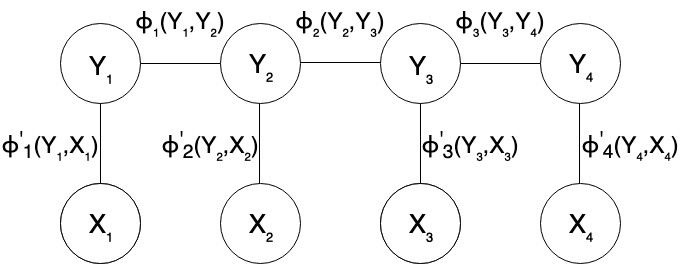

In [ ]:
#!pip install -U spacy
#!python -m spacy download ru_core_news_md

In [ ]:
import spacy

# Загружаем модель
nlp_ru = spacy.load('ru_core_news_md')

# Передаем текст в модель
doc = nlp_ru(text)

#### Синтаксическая зависимость (Syntactic dependency DEP)

DEP показывает связи между токенами

Построим дерево зависимостей с помощью displaCy

In [ ]:
from spacy import displacy

# Outside of jupyter, use displacy.serve()
displacy.render(doc, style='dep', jupyter=True)

### Визуализация сущностей

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

 ### Результаты и Оценка
SpaCy смогла выделить 47 сущностей:
- LOC    25
- ORG    16
- PER     6


Экспертная оценка показала, что SpaCy выдялет те же сущноссти, что и NATASHA. Однако можно заметить, что их общее количество составляет 47. SpaCy ошибочно выделяет слово "Определено" как персону, что, конечно, ошибочно.

 Кроме того, мы можем заметить, что в процессе визуализации выдялеются сущности типа LOC, однако если мы посмотрим их расшифровку, то это non-GPE locations.

К GPE относятся countries, cities, states. В случае нашего текста страны неверно опредялются, им присвоивается сущность LOC, хотя, на самом деле, они являются представителями GPE.

Однако, если мы посмотрим на возвожные named entities в ru_core_news_md, то увидим присутствие только 3 сущностей: LOC, ORG, PER. Таким образом, модель работает исправно в силу своих особенностей.


In [ ]:
spacy.explain('GPE')

'Countries, cities, states'

In [ ]:

# Get all the available entity types
all_entity_types = nlp_ru.get_pipe("ner").labels

print("All possible Named Entity types in ru_core_news_md model:")
for ent_type in all_entity_types:
    print(ent_type)




All possible Named Entity types in ru_core_news_md model:
LOC
ORG
PER


## Трансформеры для задачи NER: BERT

BERT (Bidirectional Encoder Representations from Transformers) представляет собой
революционную модель в области обработки естественного языка (NLP).

• BERT разработан для понимания и обработки языка, читая текст с начала и с конца
одновременно.

Зачем нужен BERT в задаче NER?

• Традиционные методы распознавания именованных сущностей (NER) испытывают
трудности в улавливании сложного контекста и нюансов, присутствующих в
естественном языке.

• Эти методы часто требуют ручного создания признаков и/или не обладают
возможностью учитывать двунаправленные отношения между словами в
предложении

• В результате они не справляются со сложностью языка, особенно в сценариях, где
значение сущности глубоко связано с ее окружающим контекстом.

Для работы с русским текстом будем использовать модели от [DeepPavlov](https://docs.deeppavlov.ai/en/master/features/models/NER.html).

Остановим свой выбор на двух моделях:
- ner_rus_bert
- ner_ontonotes_bert_mult

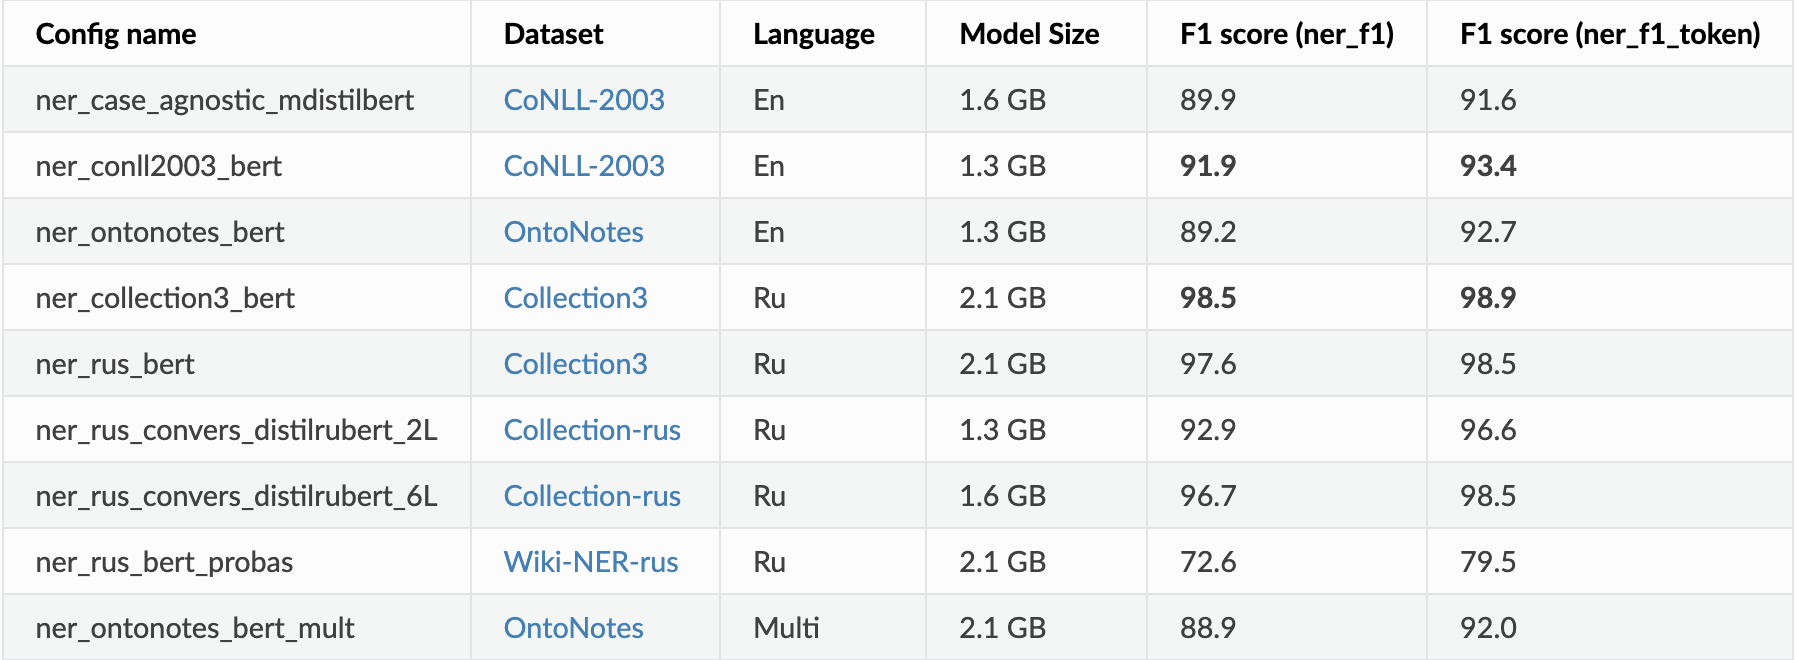

Как мы можем заметить, ner_rus_bert обучалась только на русском наборе данных, в то время как ner_ontonotes_bert_mult на нескольких. Таким образом, будет интересно посмотреть на полученные результаты.

In [ ]:
text

'Китайские закупки российского угля резко сократились в январе—феврале 2024 года после того, как Пекин вновь ввел импортные пошлины, которые делают российские поставки менее конкурентоспособными, сообщил Bloomberg со ссылкой на данные китайской таможни. Общий объем импорта угля в Китай за январь—февраль вырос на 23% в годовом исчислении, до 74,5 млн т, а импорт ресурса из России упал на 22%, до 11,5 млн т. Импортные пошлины были восстановлены в начале года, хотя другие крупные поставщики, включая Индонезию и Австралию, не пострадали благодаря соглашениям о свободной торговле с Пекином, передает агентство. Китай отменял тарифы на импорт российского угля в мае 2022 года на фоне резкого роста цен на энергоносители. Это помогло увеличить поставки ресурса из России до рекордных значений в 2023 году. Теперь\xa0же политика сместилась в сторону защиты горнодобывающих компаний от последствий перенасыщения рынка после того, как производство угля в самом Китае выросло до рекордно высокого уровня,

Модели на вход принимают токены. Возьмем предложение за токен.

Документация от deeppavlov предоставляет следующий пример:

ner_model(['Bob Ross lived in Florida', 'Elon Musk founded Tesla'])

In [ ]:
import nltk
nltk.download('punkt')
sentences = nltk.sent_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
sentences

['Китайские закупки российского угля резко сократились в январе—феврале 2024 года после того, как Пекин вновь ввел импортные пошлины, которые делают российские поставки менее конкурентоспособными, сообщил Bloomberg со ссылкой на данные китайской таможни.',
 'Общий объем импорта угля в Китай за январь—февраль вырос на 23% в годовом исчислении, до 74,5 млн т, а импорт ресурса из России упал на 22%, до 11,5 млн т. Импортные пошлины были восстановлены в начале года, хотя другие крупные поставщики, включая Индонезию и Австралию, не пострадали благодаря соглашениям о свободной торговле с Пекином, передает агентство.',
 'Китай отменял тарифы на импорт российского угля в мае 2022 года на фоне резкого роста цен на энергоносители.',
 'Это помогло увеличить поставки ресурса из России до рекордных значений в 2023 году.',
 'Теперь\xa0же политика сместилась в сторону защиты горнодобывающих компаний от последствий перенасыщения рынка после того, как производство угля в самом Китае выросло до рекордно

Модель выдает два списка.

Первый список содержит списки с исходными текстами, а второй список содержит списки с метками сущностей. 'O' означает, что данный токен не является сущностью, а 'B-LOC' и 'B-ORG' означают начало локации и организации соответственно.

 Для дальнейшего удобства визуализации результатов необходимо преобразовать вывод модели в читабельный вид, а именно: датафрейм с двумя колонками-парами (токен-сущность).

In [ ]:
#напишем функцию для этой цели
def create_dataset(texts_labels_data):
    dataset = []

    for texts, labels_list in zip(texts_labels_data[0], texts_labels_data[1]):
        for tokens, labels in zip(texts, labels_list):
            dataset.append([tokens, labels])

    df = pd.DataFrame(dataset, columns=['Token', 'Entity'])

    return df

In [ ]:
#!pip install deeppavlov

In [ ]:
#!pip install torch~=1.13.1

In [ ]:
import deeppavlov
import torch

### Импортируем предобученный **ner_ontonotes_bert_mult**

In [ ]:
from deeppavlov import configs, build_model

ner_ontonotes_bert_mult = build_model(configs.ner.ner_ontonotes_bert_mult, download=True)

2024-03-26 14:06:18.732 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/v1/ner/ner_ontonotes_bert_mult_torch_crf.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/v1/ner/ner_ontonotes_bert_mult_torch_crf.tar.gz download because of matching hashes
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and a

In [ ]:
sent2 = ner_ontonotes_bert_mult(sentences)
# Создание датасета с помощью функции
dataset2 = create_dataset(sent2)

dataset2 = dataset2[dataset2['Entity'] != 'O']
dataset2

,Token,Entity
0,Китайские,B-NORP
2,российского,B-NORP
7,январе,B-DATE
8,—,I-DATE
9,феврале,I-DATE
...,...,...
572,ФСБ,B-ORG
573,Бортникова,B-PERSON
578,Крокусе,B-LOC
583,Володин,B-PERSON


In [ ]:
#160 сущностей
dataset2.shape

(160, 2)

In [ ]:
# Подсчет количества каждой категории
split_counts = dataset2['Entity'].value_counts()

# Вывод результатов
print(split_counts)

I-DATE        32
B-DATE        26
B-GPE         23
B-ORG         14
I-QUANTITY    10
B-NORP         8
I-CARDINAL     7
I-ORG          6
B-QUANTITY     5
B-PERSON       5
B-LOC          5
B-CARDINAL     5
I-PERCENT      4
B-PERCENT      4
B-ORDINAL      2
I-PERSON       1
B-MONEY        1
I-MONEY        1
B-TIME         1
Name: Entity, dtype: int64


In [ ]:
import pandas as pd
#функция для красивой статистики
def merge_entities(df):
    new_df = pd.DataFrame(columns=['Token', 'Entity'])
    current_entity = []
    current_label = None

    for index, row in df.iterrows():
        label = row['Entity'][0]
        entity = row['Entity'][2:]

        if label == 'B':  # если начинается новая сущность
            if current_label is not None:
                new_df = pd.concat([new_df, pd.DataFrame({'Token': [' '.join(current_entity)], 'Entity': [current_label]})], ignore_index=True)
                current_entity = []

            current_label = entity
            current_entity.append(row['Token'])

        elif label == 'I' or label == 'E':  # продолжение предыдущей сущности или её завершение
            current_entity.append(row['Token'])

    # добавляем последнюю сущность
    if current_label is not None:
        new_df = pd.concat([new_df, pd.DataFrame({'Token': [' '.join(current_entity)], 'Entity': [current_label]})], ignore_index=True)

    return new_df

df2 = merge_entities(dataset2)
df2

,Token,Entity
0,Китайские,NORP
1,российского,NORP
2,январе — феврале 2024 года,DATE
3,Пекин,GPE
4,российские,NORP
...,...,...
94,ФСБ,ORG
95,Бортникова,PERSON
96,Крокусе,LOC
97,Володин,PERSON


In [ ]:
# Подсчет количества каждой категории
split_counts = df2['Entity'].value_counts()

# Вывод результатов
print(split_counts)

DATE        26
GPE         23
ORG         14
NORP         8
QUANTITY     5
PERSON       5
LOC          5
CARDINAL     5
PERCENT      4
ORDINAL      2
MONEY        1
TIME         1
Name: Entity, dtype: int64


### Результаты и Оценка

Выше мы можем наблюдать статистику для преобразованного вывода модели. Тк на выходе мы получаем токен и соответсвуюущую ему сущность согласно BIOES-схеме, то необходимо было преобразовать результаты для упрощеня экспертной оценки и понимания результатов.

ner_ontonotes_bert_mult определяет 12 сущностей.

Экспертная оценка показала, что ner_ontonotes_bert_mult совершил 5 ошибок.

- *«* (простая ковычка) была отнесена к  
  B-ORG (что верно, однако Мечела была снова определена как B-ORG), хотя она относится к Мечела, которая является организацией.
- *Почти 588 тыс.* отнес к cardinal, хотя если мы посмотрим на текст, то полная сущность должна выглядеть как *почти 588 тыс. т,* что делает ее quantity
 - Тоже самое касается *576 тыс.*, *587 тыс.*, *1*. Всем этим выражениям не хватило *т*.

### Импортируем предобученный **ner_rus_bert**

In [ ]:
ner_rus_bert = build_model('ner_rus_bert', download=True, install=True)

2024-03-26 14:07:44.189 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz download because of matching hashes


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initializ

In [ ]:
sent1 = ner_rus_bert(sentences)
# Создание датасета с помощью функции
dataset1 = create_dataset(sent1)

dataset1 = dataset1[dataset1['Entity'] != 'O']
dataset1

,Token,Entity
16,Пекин,B-LOC
30,Bloomberg,B-ORG
43,Китай,B-LOC
65,России,B-LOC
89,Индонезию,B-LOC
91,Австралию,B-LOC
101,Пекином,B-LOC
106,Китай,B-LOC
131,России,B-LOC
161,Китае,B-LOC


In [ ]:
#52 сущности
dataset1.shape

(52, 2)

In [ ]:
# Подсчет количества каждой категории
split_counts = dataset1['Entity'].value_counts()

# Вывод результатов
print(split_counts)

B-LOC    25
B-ORG    15
I-ORG     6
B-PER     5
I-PER     1
Name: Entity, dtype: int64


In [ ]:
df4 = merge_entities(dataset1)
split_counts = df4['Entity'].value_counts()

# Вывод результатов
print(split_counts)

LOC    25
ORG    15
PER     5
Name: Entity, dtype: int64


In [ ]:
df4[df4['Entity'].str.contains('ORG')]

,Token,Entity
1,Bloomberg,ORG
10,Bloomberg,ORG
12,СУЭК,ORG
13,Мечела,ORG
19,Китайской ассоциации транспортировки и распред...,ORG
20,Reuters,ORG
21,Kpler,ORG
30,Минфин,ORG
32,Банк России,ORG
34,РБК,ORG


### Результаты и Оценка

ner_rus_bert, как NATASHA и SpaCy определяет три категории сущностей: LOC, ORG, PER, показывая следующие результаты:

- LOC 25
- ORG 15
- PER 5

Экспертная оценка показала, что модель не смогла определить Telegram как организацию.

### Сравнение bertов
Давайте посмотрим, какие сущности выдают модели

- **ner_rus_bert (3)**: LOC, PER, ORG
- **ner_ontonotes_bert_mult (12)**: NORP, DATE, GPE, ORG, PERCENT, QUANTITY, ORDINAL, PERSON, LOC, CARDINAL, MONEY, TIME

При этом на 3 категории сущностей у ner_rus_bert приходится 1 ошибка, а у ner_ontonotes_bert_mult - 5.

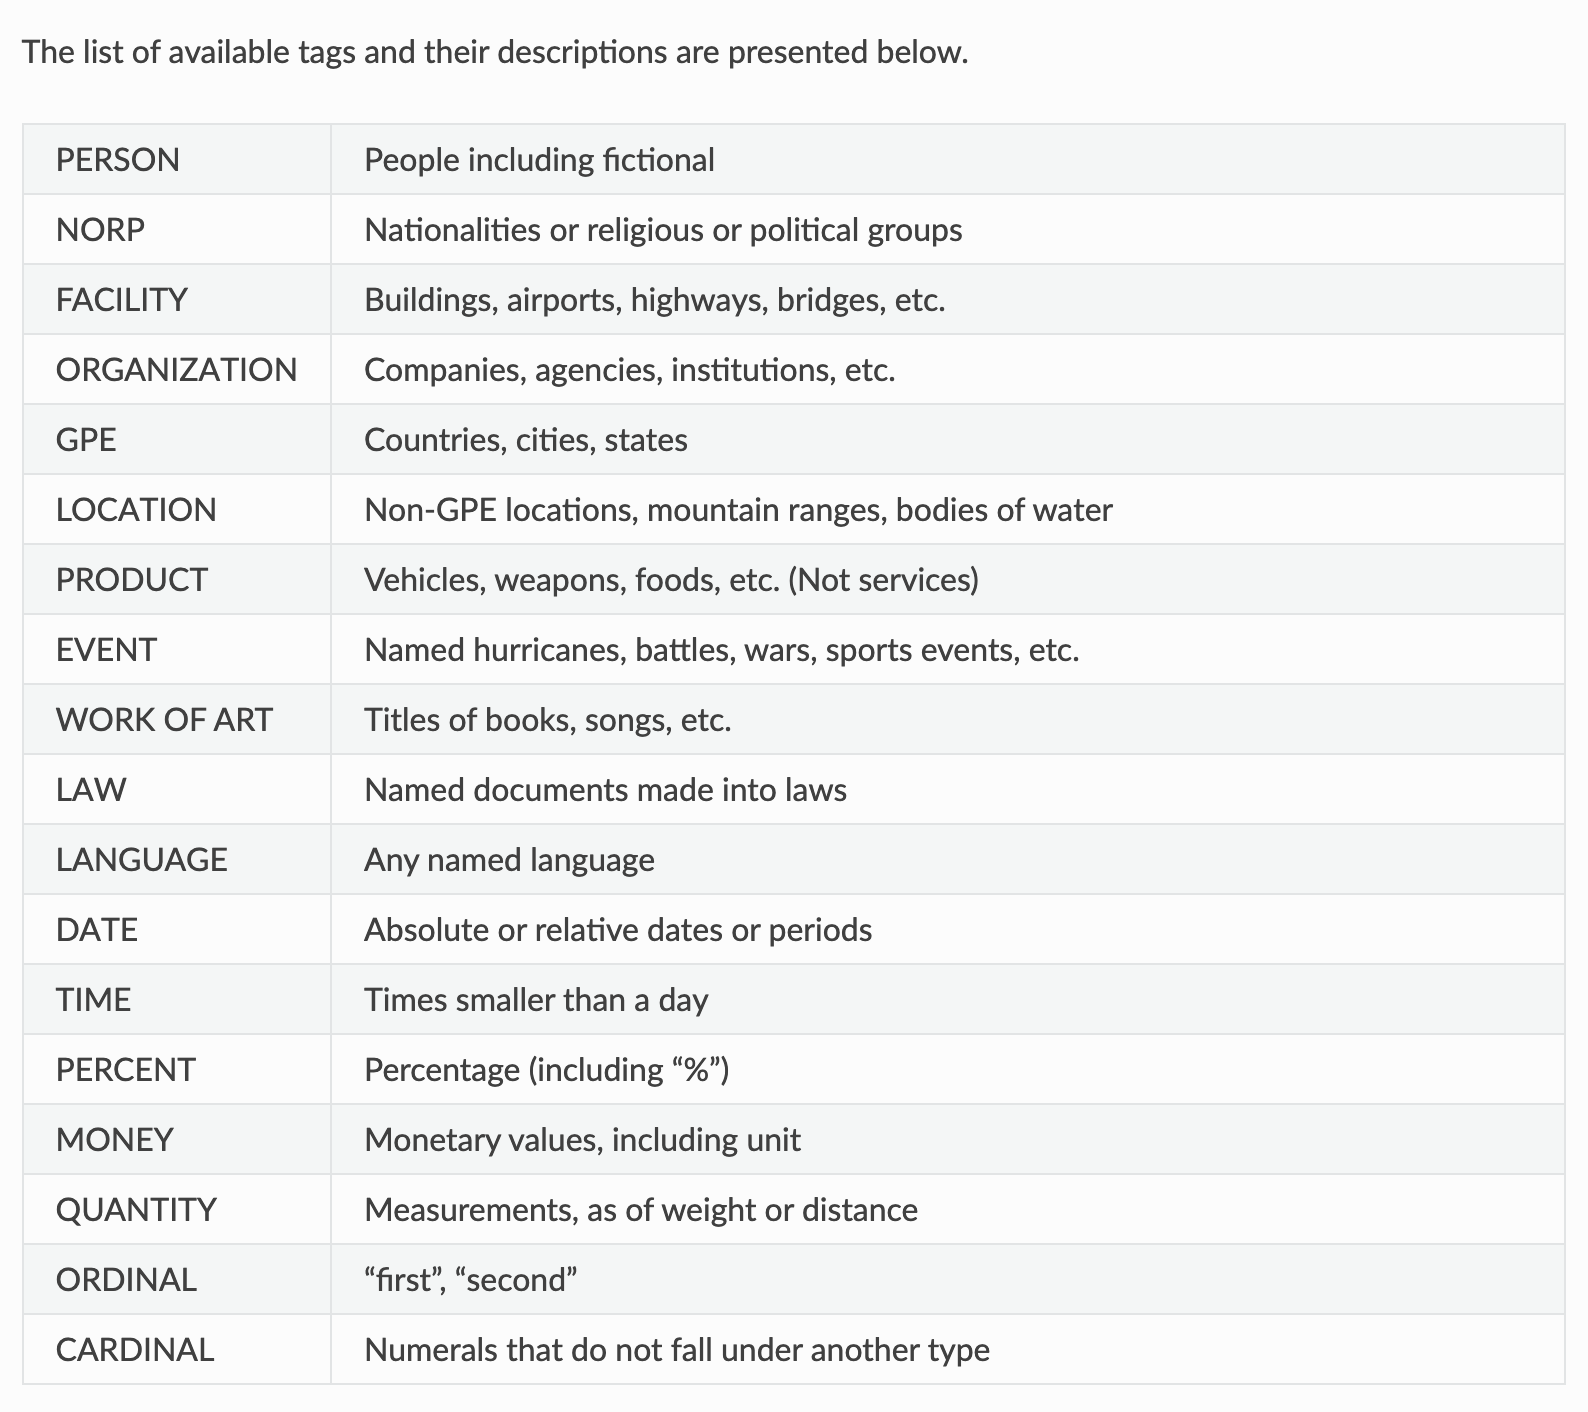

 ## Выводы

 В ходе данной работы рассматривались 4 предобученные модели: Natasha, SpaCy, ner_rus_bert, ner_ontonotes_bert_mult.

 Natasha, ner_rus_bert и SpaCy умеют определять одинаковое количество и состав категорий (LOC, ORG, PER). В то время как Natasha определила все сущности верно, ner_rus_bert и SpaCy совершили каждая по одной ошибке, неверно идентифицировав или не индентифицировав PER и ORG соответственно. Тем не менее, dates_extractor от Natasha также не был четок во всем.

В свою очередь, ner_ontonotes_bert_mult смог определить 12 категорий сущностей, совершив 5 ошибок.

Таким образом, наилучший результат показала Natasha.